<a href="https://colab.research.google.com/github/mohsenMahmoodzadeh/Image-Caption-classification-with-tensorflow-Keras/blob/master/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with Keras

In this notebook, we build a keras model to classify a text dataset with 2658 train and 2658 test senetences. 

We use Tensorflow and Keras for implementation of our model. 

We also use scikit-learn library for some ancillary affairs such as confusion matrix, accuracy score, classification report, etc.

In [1]:
import tensorflow as tf
import tensorflow.keras as K
import random
import numpy as np
import pandas as pd
import h5py
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D,Activation,MaxPool2D,Dropout,Dense,Flatten,Input,BatchNormalization
from tensorflow.keras.models import Sequential,load_model,Model
from matplotlib import pyplot as plt
from collections import Counter
import os
import cv2
import warnings
warnings.filterwarnings('ignore','FutureWarning')

In [2]:
label_map = {
    0 : 'aeroplane', 1 : 'bicycle', 2 : 'bird', 3 : 'boat', 
    4 : 'bus', 5 : 'car', 6 : 'cat', 7 : 'chair', 8 : 'cow',
    9 : 'diningtable', 10 : 'dog', 11 : 'horse', 12 : 'motorbike',
    13 : 'person', 14 : 'pottedplant', 15 : 'sheep', 16 : 'sofa',
    17 : 'train', 18 : 'tvmonitor'
  }

In [3]:
CATEGORIES = list(label_map.values())

In [4]:
def read_file(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    return lines

In [5]:
def prepare_train_data(TRAIN_DATA_DIR, CATEGORIES):
    train_data = []
    path = ""
    for category in CATEGORIES:
        temp = []
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            try:
                lines = read_file(file_path)
                for line in lines:
                    temp.append(line)

            except Exception as e:
                print(str(e))
        
        for line in temp:
            train_data.append((line, class_num))
    
    return train_data

In [6]:
def prepare_test_data(TEST_DATA_DIR, CATEGORIES):
    test_data = []
    path = ""
    for category in CATEGORIES:
        temp = []
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            file = file_path
            try:
                lines = read_file(file)
                for line in lines:
                    temp.append(line)

            except Exception as e:
                print(str(e))
        
        for line in temp:
            test_data.append((line, class_num))
    return test_data

In [7]:
TRAIN_DATA_DIR = "./dataset/train/sentences/"
TEST_DATA_DIR = "./dataset/test/sentences/"
CATEGORIES = ["aeroplane", "bicycle", "bird", "boat", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", 
              "motorbike", "person", "pottedplant", "sheep","sofa", "train", "tvmonitor"]

In [54]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DATA_DIR,
    label_mode="categorical",
    validation_split=0.2,
    subset='training',
    seed= 1337 
)

Found 532 files belonging to 19 classes.
Using 426 files for training.


In [55]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DATA_DIR,
    label_mode="categorical",
    validation_split=0.2,
    subset='validation',
    seed= 1337 
)

Found 532 files belonging to 19 classes.
Using 106 files for validation.


In [26]:
# raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     label_mode="categorical"
# )

Found 532 files belonging to 19 classes.


In [56]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TEST_DATA_DIR,
    label_mode="categorical"
)

Found 380 files belonging to 19 classes.


In [57]:
max_features = None
embedding_dim = 128
sequence_length = 256

In [58]:
vectorization_layer = \
        tf.keras.layers.experimental.preprocessing.TextVectorization(
#             max_tokens = max_features,
            output_mode = "int",
            output_sequence_length = sequence_length,
        )

In [59]:
text_ds = raw_train_ds.map(lambda x, y: x)
vectorization_layer.adapt(text_ds)

In [60]:
max_features = vectorization_layer.vocabulary_size()

In [61]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorization_layer(text), label

In [62]:
train_ds = raw_train_ds.map(vectorize_text)
# val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [10]:
# training_data = prepare_train_data(TRAIN_DATA_DIR, CATEGORIES)
# test_data = prepare_test_data(TEST_DATA_DIR, CATEGORIES)

In [11]:
# random.shuffle(training_data)
# random.shuffle(test_data)

In [12]:
# def extract_X_and_y(data):
#   data_dict = {}
#   X = []
#   y = []
#   for example in data:
#     X.append(example[0])
#     y.append(example[1])
#   data_dict['X'] = X
#   data_dict['y'] = y
#   return data_dict

In [23]:
# val_data_size = int(len(training_data) * 0.3)
# val_data = training_data[:val_data_size]
# training_data = training_data[val_data_size:]

In [24]:
# training_dict = extract_X_and_y(training_data)
# X_train = training_dict['X']
# y_train = training_dict['y']

In [25]:
# val_dict = extract_X_and_y(val_data)
# X_val = val_dict['X']
# y_val = val_dict['y']

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)

In [26]:
# test_dict = extract_X_and_y(test_data)
# X_test = test_dict['X']
# y_test = test_dict['y']

In [ ]:
# vectorization_layer = \
#         tf.keras.layers.experimental.preprocessing.TextVectorization()

In [ ]:
# vectorization_layer.adapt(X_train)

In [27]:
def create_data_model(data, embedding_dim):
    pass
#         vectorization_layer = \
#         tf.keras.layers.experimental.preprocessing.TextVectorization()
    
#     vectorization_layer.adapt(data)
    
#     embedding_layer = tf.keras.layers.Embedding(
#         input_dim = len(vectorization_layer.get_vocabulary()),
#         output_dim = embedding_dim,
#         mask_zero=True
#     )
    
#     return tf.keras.Sequential(
#         [
#            vectorization_layer,
#            embedding_layer,
#            tf.keras.layers.GlobalAveragePooling1D()
#         ]
#     )

In [28]:
# X_train_model = create_data_model(X_train, 32)

In [29]:
# X_val_model = create_data_model(X_val, 32)

In [30]:
# X_test_model = create_data_model(X_test, 32)

In [ ]:
# def clean_data(text):  
#   word_tokens= text.lower().split()
#   le=WordNetLemmatizer()
#   stop_words= set(stopwords.words("english"))     
#   word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
  
#   cleaned_data=" ".join(word_tokens)
#   return cleaned_data

In [14]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# cleaned_X_train = []
# for tr_example in X_train:
#   cleaned_data = clean_data(tr_example)
#   cleaned_X_train.append(cleaned_data)
#   # tokenizer.fit_on_texts(tr_example.strip())

In [ ]:
# cleaned_X_val = []
# for val_example in X_val:
#   cleaned_data = clean_data(tr_example)
#   cleaned_X_val.append(cleaned_data)

In [ ]:
# cleaned_X_test = []
# for test_example in X_test:
#   cleaned_data = clean_data(test_example)
#   cleaned_X_test.append(cleaned_data)

In [15]:
# vocab_size = 2304 
# oov_token = '<OOV>' #OOV = Out of Vocabulary
# tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
# maxlen = 100
# padding_type = 'post'

In [16]:
# def remove_stopwords(data):
#   STOPWORDS= set(stopwords.words("english"))     
#   no_sw_data = []
#   for example in data:
#       for word in STOPWORDS:
#           token = ' ' + word + ' '
#           example = example.replace(token, ' ')
#           example = example.replace(' ', ' ')
#       no_sw_data.append(example)
#   return no_sw_data

In [17]:
# X_train = remove_stopwords(X_train)
# tokenizer.fit_on_texts(X_train)
# X_train = tokenizer.texts_to_sequences(X_train)
# X_train = pad_sequences(X_train, maxlen=maxlen, padding=padding_type)
# y_train_cat = tf.keras.utils.to_categorical(y_train)

In [ ]:
# X_val = remove_stopwords(X_val)
# tokenizer.fit_on_texts(X_val)
# X_val = tokenizer.texts_to_sequences(X_val)
# X_val = pad_sequences(X_val, maxlen=maxlen, padding=padding_type)
# y_val_cat = tf.keras.utils.to_categorical(y_val)

In [18]:
# X_test = remove_stopwords(X_test)
# tokenizer.fit_on_texts(X_test)
# X_test = tokenizer.texts_to_sequences(X_test)
# X_test = pad_sequences(X_test, maxlen=maxlen, padding=padding_type)
# y_test_cat = tf.keras.utils.to_categorical(y_test)

In [19]:
# import zipfile
# zip_ref = zipfile.ZipFile('/content/drive/MyDrive/glove.6B.zip', 'r')
# zip_ref.extractall('/content/')
# zip_ref.close()

In [ ]:
# import gensim
# sentences= cleaned_X_train + cleaned_X_val + cleaned_X_test
# w2v_model=gensim.models.Word2Vec(sentences= sentences, size=300, window=10, min_count=1)

In [ ]:
# w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

In [ ]:
# vocab=w2v_model.wv.vocab
# print("The total number of words are : ",len(vocab))

In [ ]:
# vocab=list(vocab.keys())

In [ ]:
# word_vec_dict={}
# for word in vocab:
#   word_vec_dict[word]=w2v_model.wv.get_vector(word)
# print("The no of key-value pairs : ",len(word_vec_dict))

In [ ]:
# tokenizer.fit_on_texts(sentences)
# vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# tokenizer.fit_on_texts(cleaned_X_rtain)
# X_train = tokenizer.texts_to_sequences(cleaned_X_rtain)
# X_train = pad_sequences(X_train, maxlen=maxlen, padding=padding_type)
# y_train_cat = tf.keras.utils.to_categorical(y_train)

In [ ]:
# tokenizer.fit_on_texts(cleaned_X_val)
# X_val = tokenizer.texts_to_sequences(cleaned_X_val)
# X_val = pad_sequences(X_val, maxlen=maxlen, padding=padding_type)
# y_val_cat = tf.keras.utils.to_categorical(y_val)

In [ ]:
# tokenizer.fit_on_texts(cleaned_X_test)
# X_test = tokenizer.texts_to_sequences(cleaned_X_test)
# X_test = pad_sequences(X_test, maxlen=maxlen, padding=padding_type)
# y_test_cat = tf.keras.utils.to_categorical(y_test)

In [20]:
# def create_embedding_matrix(filepath, word_index, embedding_dim):
#     vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
#     embedding_matrix = np.zeros((vocab_size, embedding_dim))

#     with open(filepath) as f:
#         for line in f:
#             word, *vector = line.split()
#             if word in word_index:
#                 idx = word_index[word] 
#                 embedding_matrix[idx] = np.array(
#                     vector, dtype=np.float32)[:embedding_dim]

#     return embedding_matrix

In [21]:
# embedding_dim = 50
# embedding_matrix = create_embedding_matrix('/content/glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

In [22]:
# nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
# nonzero_elements / vocab_size

0.9800347222222222

In [68]:
def create_model(max_features, embedding_dim):
    
    num_classes = 19
    
    model = Sequential()
    
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    x = tf.keras.layers.Embedding(max_features, embedding_dim)(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv1D(128, 9, padding="valid", activation="relu", strides=3)(x)
    x = tf.keras.layers.Conv1D(128, 9, padding="valid", activation="relu", strides=3)(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax", name="predictions")(x)
    
    model = tf.keras.Model(inputs, predictions)
#     model.add(layers.Embedding(vocab_size, embedding_dim, 
#                             weights=[embedding_matrix], 
#                             input_length=maxlen, 
#                             trainable=True
#                             ))
#     model.add(layers.Conv1D(128, 5, activation='relu'))
#     model.add(layers.GlobalMaxPool1D())
#     model.add(layers.Dropout(0.3))
#     model.add(layers.Dense(20, activation='relu'))
#     model.add(layers.Dense(num_classes, activation='softmax'))

#     model.compile(optimizer='adam',
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])
    return model


In [ ]:
# plt.style.use('ggplot')

# def plot_history(history):
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     x = range(1, len(acc) + 1)

#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(x, acc, 'b', label='Training acc')
#     plt.plot(x, val_acc, 'r', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(x, loss, 'b', label='Training loss')
#     plt.plot(x, val_loss, 'r', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.legend()

In [ ]:
# print(vocab_size)

In [63]:
model = create_model(max_features, embedding_dim)

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [69]:
epochs = 30
history = model.fit(train_ds,
                    epochs = epochs,
                    validation_data = val_ds
                )

Epoch 1/30
14/14 [==============================] - 4s 239ms/step - loss: 0.1270 - accuracy: 0.9507 - val_loss: 1.7334 - val_accuracy: 0.6698
Epoch 2/30
14/14 [==============================] - 3s 228ms/step - loss: 0.1188 - accuracy: 0.9671 - val_loss: 1.7557 - val_accuracy: 0.6981
Epoch 3/30
14/14 [==============================] - 4s 248ms/step - loss: 0.0919 - accuracy: 0.9789 - val_loss: 1.9338 - val_accuracy: 0.6415
Epoch 4/30
14/14 [==============================] - 4s 236ms/step - loss: 0.1047 - accuracy: 0.9742 - val_loss: 1.7996 - val_accuracy: 0.6604
Epoch 5/30
14/14 [==============================] - 4s 258ms/step - loss: 0.1017 - accuracy: 0.9695 - val_loss: 2.0646 - val_accuracy: 0.6226
Epoch 6/30
14/14 [==============================] - 4s 246ms/step - loss: 0.1206 - accuracy: 0.9577 - val_loss: 1.9201 - val_accuracy: 0.6981
Epoch 7/30
14/14 [==============================] - 4s 240ms/step - loss: 0.1061 - accuracy: 0.9695 - val_loss: 1.9396 - val_accuracy: 0.6981
Epoch 

In [70]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label = "training")
    plt.plot(epochs, val_acc, label = "validation")
    plt.legend(loc="upper left")
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label = "training")
    plt.plot(epochs, val_loss, label = "validation")
    plt.legend(loc="upper right")
    plt.title('Training and validation loss')

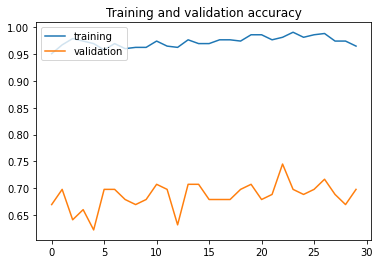

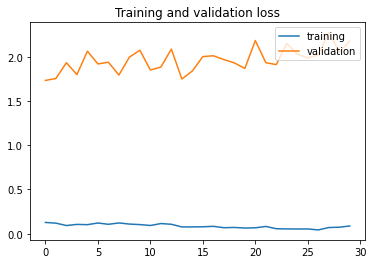

In [71]:
plot_history(history)

In [103]:
# TODO: Earn Confusion Matrix and Classification Report for the model

# print('Confusion Matrix')
# print(confusion_matrix(y_test.values.argmax(axis=1), y_pred))

# print()

# print('Classification Report')
# print(classification_report(tf.keras.utils.to_categorical(y_test), 
#                             y_pred, 
#                             target_names=CATEGORIES))

In [72]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Testing Loss: {:.4f}".format(test_loss))
print("Testing Accuracy:  {:.4f}".format(test_accuracy))

12/12 [==============================] - 1s 64ms/step - loss: 2.3969 - accuracy: 0.6658


[2.3969192504882812, 0.6657894849777222]

In [ ]:
# TODO: K-fold Cross Validation!

In [42]:
# X_train = np.concatenate([x for x, y in train_ds], axis=0)
# X_test = np.concatenate([x for x, y in test_ds], axis=0)

In [29]:
# y_train = np.concatenate([y for x, y in train_ds], axis=0)
# y_val = np.concatenate([y for x, y in val_ds], axis=0)
# y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [49]:
# inputs = train_ds.concatenate(test_ds)
# inputs = train_ds.concatenate(val_ds).concatenate(test_ds)
# inputs = np.concatenate([X_train, X_test], axis=0)

# targets = np.concatenate([y_train, y_val, y_test])
# targets = np.concatenate([y_train, y_test])
# fold_no = 5

In [75]:
# def cross_validate(X, y, K = 5, **kwargs):
#     scores = []
#     histories = []
#     learning_rate = 0.0001
#     optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)
#     metrics = ['accuracy']
#     loss = "categorical_crossentropy"
#     epochs = 30
#     batch_size = 32
    
#     for train_data, test_data in KFold(n_splits = K, shuffle = True).split(X,y):
        
#         model = create_model(max_features, embedding_dim)
#         model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
        
#         histories.append(
#             model.fit(
#                 X[train_data], 
#                 y[train_data],
#                 epochs = epochs
#             )
#             .history
#         )
        
#         scores.append(
#             model.evaluate(
#                 X[test_data], 
#                 y[test_data], 
#                 verbose = 0
#             )
#         )
        
#     print("Average test loss: ", np.asarray(scores)[:, 0].mean())
#     print("Average test accuracy: ", np.asarray(scores)[:, 1].mean())
    
#     return scores, histories

In [76]:
# scores, histories = cross_validate(inputs, targets, K = fold_no)

## Resources

1. https://realpython.com/python-keras-text-classification/
2. https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory
3. https://nlp.stanford.edu/projects/glove/
4. https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
5. https://stackoverflow.com/questions/45117295/what-is-the-relation-between-validation-data-and-validation-split-in-keras-fit
6. https://towardsdatascience.com/addressing-the-difference-between-keras-validation-split-and-sklearn-s-train-test-split-a3fb803b733
7. https://towardsdatascience.com/data-augmentation-library-for-text-9661736b13ff
8. https://github.com/makcedward/nlpaug
9. https://www.depends-on-the-definition.com/guide-to-word-vectors-with-gensim-and-keras/
10. https://code.google.com/archive/p/word2vec/